<h1>How Stacked Model and Filter and Refine is working </h1>
<ul>
    Requirement
  <li>Trained CRF model (Train_DS_model.ipynb)<br></li>
  <li>Test Corpus</li>
</ul>


In [1]:
cd ..

/mount/SEFR_CUT


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pickle
import math
import copy as cp
from itertools import accumulate
import operator

In [3]:
from sefr_cut.preprocessing import preprocess
prepro = preprocess()
import sefr_cut.extract_features as extract_features

In [4]:
'''
path_corpus : put your training corpus in corpus/ and put the folder name here
y_pred : y from deepcut shape(#sentence,#character in sentence) ex. [[1,0,0,0,.....,0],[1,0,0,1,....,0]]
y_entropy : entropy calcuated from y_prob shape(#sentence,#character in sentence) ex. [[0.01,0.1,0.15,.....,0],[0.01,0.2,0.45,.....,0]]
y_prob : probability from softmax layer shape(#sentence,#character in sentence) ex. [[0.01,0.1,0.15,.....,0],[0.01,0.2,0.45,.....,0]]
'''
#path_corpus = ['CORPUS_FOLDER_NAME']
path_corpus = ['Notebooks/corpus/wisesight']
# create x,y
x,y_true = prepro.preprocess_x_y(path_corpus)

# 2D to 1D
y_true = [j for sub in y_true for j in sub if len(j) > 1]
x = [j for sub in x for j in sub if len(j) > 1]

y_pred,y_entropy,y_prob = prepro.predict_(x) # DeepCut Baseline


In [5]:
import pycrfsuite
CRF_model_name = 'my_model.model'
crf_model_ds = pycrfsuite.Tagger() 
crf_model_ds.open(f'Notebooks/model/{CRF_model_name}') 

In [7]:
#in seft_cut we use numpy instead of list :( 
def return_max_index(number_ranking,entropy_list):
    index_entropy = []
    func_entro_list = entropy_list[:]
    ranking_ = int(len(entropy_list)*(number_ranking/100))
    for i in range(ranking_):
        index, max_num = max(enumerate(func_entro_list), key=operator.itemgetter(1))
        func_entro_list[index] = -math.inf
        index_entropy.append(index)
    return index_entropy

def scoring_function_crf(y_pred,index):
    result = y_pred[:]
    for i,items in enumerate(index):
        x_data = extract_features.extract_features_crf(x[i],y_entropy[i],y_prob[i])
        for idx in items:
            y_pred_crf = crf_model_ds.tag(x_data[idx])
            result[i][idx] = int(y_pred_crf[0])
    return result

# If you want to understand how perfect of filter and refind you can use this scoring function instead scoring_function_crf
def scoring_function(y_true_,y_pred,index):
    result = y_pred[:]
    for idx,items in enumerate(index):
        for idx_item in items:
            try:
                result[idx][idx_item] = y_true_[idx][idx_item]
            except:
                print(f'random:{idx},{idx_item} result:{len(result)},{len(result[idx])} y_true:{len(y_true)},{len(y_true[idx])}')
    return result

In [8]:
def cut(y_pred_boolean,x_data):
    x_ = cp.deepcopy(x_data)
    answer = []
    for idx,items in enumerate(y_pred_boolean):
        text = ""
        for index,item in enumerate(items):
            if(item == 1):
                text +='|'
            text +=x_[idx][index]
        answer.append(text)
    return answer 

# in filter and refine evaluation we use F1-score character level
def eval_function(y_true,y_pred):
    f1_score_entropy=[]; 
    for index,_ in enumerate(y_pred):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true[index], y_pred[index], average='binary')
        f1_score_entropy.append(fscore)
    return np.mean(f1_score_entropy)

In [9]:
def score_(K_num,start,step):
    K_num+=step
    f1_original = []
    f1_crf_og=[]
    f1_hypothesis=[]
    y_true_data = [j for sub in y_true for j in sub]
    y_original_data = [j for sub in y_pred for j in sub]
    for K in range(start,K_num,step):
        entropy_index_og = [return_max_index(K,value) for value in y_entropy] # Find entropy index from DC Baseline
        
        answer_crf_original = scoring_function_crf(cp.deepcopy(y_pred),entropy_index_og) # DeepCut+CRF
        y_test_data = [j for sub in answer_crf_original for j in sub] #2d to 1d
        
        f1_original.append(eval_function([y_true_data],[y_original_data])) # F1 DeepCut
        f1_crf_og.append(eval_function([y_true_data],[y_test_data]))# F1 CRF+DeepCut
        
        # If you want to know how perfect of filter and refine you can use this function
        #answer = scoring_function(y_true,cp.deepcopy(y_pred),entropy_index_og)
        #f1_hypothesis.append(eval_function(y_true,answer))
        
        
    #%matplotlib notebook
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_xlabel('K percentage candidate',fontsize=18)
    ax.set_ylabel('F1 Score Character level',fontsize=18)
    
    # for perfect filter and refine only
    #ax.plot(range(start,K_num,step),f1_hypothesis,c="r",marker='o',label='Best case')
    
    ax.plot(range(start,K_num,step),f1_original,c="k",label='DeepCut')
    ax.plot(range(start,K_num,step),f1_crf_og,c="g",marker='v',label='SE+DeepCut')
    
    #ax.legend(loc='center right')
    ax.legend()
    plt.show()
    
    return f1_original,f1_crf_og


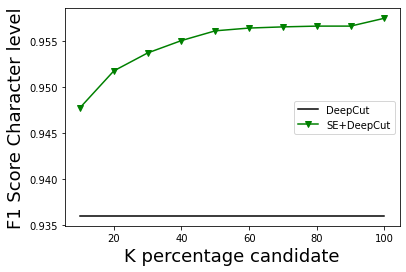

In [11]:
K_num = 100
start = 10
step = 10
f1_original,f1_crf_dg = score_(K_num=K_num,start=start,step=step)


<h1>Filter and Refine Result</h1>

In [12]:
max_gap_og = (f1_crf_dg[0]-f1_original[0])*100
index_max_og = start
print(f"BL:{f1_original[0]:.5f}")

for idx,_ in enumerate(f1_crf_dg):
    new_max_og = (f1_crf_dg[idx]-f1_original[idx])*100
    index_now = start+(idx*step)

    if max_gap_og < new_max_og:
        max_gap_og = new_max_og
        index_max_og = index_now     
    
    print(f"K:{index_now} CRF_BL:{f1_crf_dg[idx]:.7f} better than:{new_max_og:.4f}")
print(f'index og:{index_max_og} ')


BL:0.93601
K:10 CRF_BL:0.9477528 better than:1.1738
K:20 CRF_BL:0.9517490 better than:1.5734
K:30 CRF_BL:0.9536920 better than:1.7677
K:40 CRF_BL:0.9550351 better than:1.9020
K:50 CRF_BL:0.9560910 better than:2.0076
K:60 CRF_BL:0.9563908 better than:2.0376
K:70 CRF_BL:0.9565179 better than:2.0503
K:80 CRF_BL:0.9566015 better than:2.0587
K:90 CRF_BL:0.9566015 better than:2.0587
K:100 CRF_BL:0.9574547 better than:2.1440
index og:100 


<h1>Word level Evaluation

In [13]:
def SERF_CUT(entropy_y,y_deepcut,K_num):
    entropy_index = [return_max_index(K_num,value) for value in entropy_y]
    answer_crf = scoring_function_crf(cp.deepcopy(y_deepcut),entropy_index)
    return answer_crf

In [14]:
y_pred_CRF_baseline = SERF_CUT(y_entropy,y_pred,K_num=index_max_og) # set k to the best k value

In [15]:
'''
What we do here is
['สวัสดีชาวไทย','ประเทศไทย'] -> ['สวัสดีชาวไทยประเทศไทย']
Why?
To evaluate word level, the sentence need to concate !! 
Do not use sum() and average F1-score !!!
'''
y_true_1d = [j for sub in y_true for j in sub]
y_pred_1d = [j for sub in y_pred for j in sub]
y_pred_CRF_1d = [j for sub in y_pred_CRF_baseline for j in sub]
x_data = ''
for item in x:
    x_data+=item
    

deepcut_pred = cut([y_pred_1d],[x_data])
answer = cut([y_true_1d],[x_data])
crf_pred = cut([y_pred_CRF_1d],[x_data])

In [16]:
def evaluate_word(train : list, test: list) -> tuple:
    train_acc = list(accumulate(map(len, train), func = operator.add))
    test_acc = list(accumulate(map(len, test), func = operator.add))
    train_set = set(zip([0,*train_acc], train_acc))
    test_set = set(zip([0,*test_acc], test_acc))
    correct = len(train_set & test_set)
    pre = correct/len(test)
    re = correct/len(test)
    f1 = (2*pre*re)/(pre+re)
    return f1

In [17]:
deepcut_list = deepcut_pred[0].split('|')
answer_list = answer[0].split('|')
crf_list = crf_pred[0].split('|')
print(f'DeepCut Char Score: {eval_function([y_true_1d],[y_pred_1d]):.4f}')
print(f'CRF Char Score: {eval_function([y_true_1d],[y_pred_CRF_1d]):.4f}')
print()
print(f'DeepCut Word Score: {evaluate_word(answer_list,deepcut_list):.4f}')
print(f'CRF Word Score: {evaluate_word(answer_list,crf_list):.4f}')


DeepCut Char Score: 0.9360
CRF Char Score: 0.9575

DeepCut Word Score: 0.8393
CRF Word Score: 0.8813


In [18]:
dg_correct = 0; dg_wrong = 0; ds_correct = 0; ds_wrong = 0;
for idx,val in enumerate(y_true_1d):
    if y_pred_1d[idx] == val:
        dg_correct +=1
    else:
        dg_wrong +=1
    if y_pred_CRF_1d[idx] == val:
        ds_correct +=1
    else:
        ds_wrong +=1

In [19]:
print(f'All Character:{len(y_true_1d)}')
print(f'DG correct:{dg_correct}\tDG wrong:{dg_wrong} ')
print(f'DS correct:{ds_correct}\tDS wrong:{ds_wrong}')

All Character:75135
DG correct:72208	DG wrong:2927 
DS correct:73188	DS wrong:1947


<h1>Result comparison

In [18]:
x_true = cut(y_true,x) # actual result !

x_original = cut(y_pred,x) # result DeepCut(Baseline)

x_crf_og = cut(y_pred_CRF_baseline,x) # result CRF+DeepCut with the best k !

In [19]:
i=13
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|รถไฟ|ฟ้า|สร้าง|พร้อม|กัน|3|-|4|สาย|แบบ|นี้|คือ|วิกฤติ|รถ|ติด|เลย|นะ| |แต่|ข้อ|ดี|ของ|การ|สร้าง|พร้อม|กัน|คือ|เสร็จ|พร้อม|กัน|เหมือน|เสก|ไเ|ลย|ล่ะ| |กทม.|มี|แผนี|ถไฟ|13|สาย| |เปิด|แล้ว|5| |ถ้า|มัว|แต่|ทำ|ที|ละ|สาย| |กว่า|จะ|ครบ|เรา|คง|ตาย|กัน|หมด|แล้ว
DeepCut
|รถ|ไฟฟ้า|สร้าง|พร้อม|กัน|3|-|4|สาย|แบบ|นี้|คือ|วิกฤติ|รถ|ติด|เลย|นะ| |แต่|ข้อ|ดี|ของ|การ|สร้าง|พร้อม|กัน|คือ|เสร็จ|พร้อม|กัน|เหมือน|เสกไเลย|ล่ะ| |กทม.|มี|แผนีถไฟ|13|สาย| |เปิด|แล้ว|5| |ถ้า|มัว|แต่|ทำ|ที|ละ|สาย| |กว่า|จะ|ครบ|เรา|คง|ตาย|กัน|หมด|แล้ว
SE+DeepCut
|รถ|ไฟฟ้า|สร้าง|พร้อม|กัน|3|-|4|สาย|แบบ|นี้|คือ|วิกฤติ|รถ|ติด|เลย|นะ| |แต่|ข้อ|ดี|ของ|การ|สร้าง|พร้อม|กัน|คือ|เสร็จ|พร้อม|กัน|เหมือน|เสกไเลย|ล่ะ| |กทม.|มี|แผนีถไฟ|13|สาย| |เปิด|แล้ว|5| |ถ้า|มัว|แต่|ทำ|ที|ละ|สาย| |กว่า|จะ|ครบ|เรา|คง|ตาย|กัน|หมด|แล้ว
###########################################


In [20]:
i=61
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|ไม่|จ้ะ|ไม่
DeepCut
|ไม่|จ้ะ|ไม่
SE+DeepCut
|ไม่|จ้ะ|ไม่
###########################################


In [21]:
i=81
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|จัย|เลว| |มา|ซื้อ|อินนิสฟรี|ที่|โตเกียว|555555
DeepCut
|จัย|เลว| |มา|ซื้อ|อินนิสฟรี|ที่|โต|เกียว|555555
SE+DeepCut
|จัย|เลว| |มา|ซื้อ|อินนิสฟรี|ที่|โต|เกียว|555555
###########################################


In [22]:
i=83
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|พนักงาน|หน้า|บึ้ง| |ไม่|ยิ้ม|เลย
DeepCut
|พนักงาน|หน้าบึ้ง| |ไม่|ยิ้ม|เลย
SE+DeepCut
|พนักงาน|หน้า|บึ้ง| |ไม่|ยิ้ม|เลย
###########################################


In [23]:
i=91
#print(f'text\n{x[i].replace('|','')}')
print(f'Acutal\n{x_true[i]}')
print(f'DeepCut\n{x_original[i]}')
print(f'SE+DeepCut\n{x_crf_og[i]}')
print(f'###########################################')

Acutal
|อี|เหี้ยย| |วาสนา|จะ|ได้|ขับ| |mazda 2| |คือ|ล่ม|ละ| |อี|ช่าง|แม่ง|รื้อ|รถ|ออก|มา|ตรวจ|สภาพ|แล้ว|ประกอบ|กลับ|ไม่|ได้|อะ| |หนัง|หี|มาก
DeepCut
|อีเหี้ยย| |วาสนา|จะ|ได้|ขับ| |mazda| |2| |คือ|ล่ม|ละ| |อี|ช่าง|แม่งรื้อ|รถ|ออก|มา|ตรวจ|สภาพ|แล้ว|ประกอบ|กลับ|ไม่|ได้|อะ| |หนัง|หี|มาก
SE+DeepCut
|อีเหี้ยย| |วาสนา|จะ|ได้|ขับ| |mazda| |2| |คือ|ล่ม|ละ| |อี|ช่าง|แม่งรื้อ|รถ|ออก|มา|ตรวจ|สภาพ|แล้ว|ประกอบ|กลับ|ไม่|ได้|อะ| |หนัง|หี|มาก
###########################################
